# A calibrated, constrained ensemble

`fair`, like every other simple or complex climate model, is naive. It will produce projections for whatever emissions/concentrations/forcing scenario you ask it to produce projections for. It is up to the user to determine whether these projections are useful and sensible.

We have [developed a set of parameter calibrations](https://github.com/chrisroadmap/fair-calibrate) that reproduce both observed climate change since pre-industrial and assessed climate metrics such as the equilibrium climate sensitivity from the IPCC Sixth Assessement Report. These are described in this paper in review:

Smith, C., Cummins, D. P., Fredriksen, H.-B., Nicholls, Z., Meinshausen, M., Allen, M., Jenkins, S., Leach, N., Mathison, C., and Partanen, A.-I.: fair-calibrate v1.4.1: calibration, constraining and validation of the FaIR simple climate model for reliable future climate projections, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2024-708, 2024.

**Note**: if you are reading this tutorial online and want to reproduce the results, you will need a few additional files. Grab these from https://github.com/OMS-NetZero/FAIR/tree/master/examples/data/calibrated_constrained_ensemble and put them in a new folder relative to this notebook (`./data/calibrated_constrained_ensemble/`). This does not apply if you are running this notebook from Binder or have cloned it from GitHub - it should run out of the box.

The calibrations will be continually updated, as new data for surface temperature, ocean heat content, external forcing and emissions become available. For now, we have calibration version where emissions and climate constraints are updated to 2022, and assessments of emergent climate metrics are from the IPCC AR6 WG1 Chapter 7. We use emissions data from a variety of sources (Global Carbon Project, PRIMAP-Hist, CEDS, GFED), and harmonize SSP scenarios to ensure that the projections (which originally started in 2015) have a smooth transition when recent emissions are taken into account.

As described in the Smith et al. (2024) paper, a two-step constraining process is produced. The first step ensures that historical simulations match observed climate change to a root-mean-square error of less than 0.17°C. The second step simultaneously distribution-fits to the following assessed ranges:

- equilibrium climate sensitivity (ECS), very likely range 2-5°C, best estimate 3°C
- transient climate response (TCR), very likely range 1.2-2.4°C, best estimate 1.8°C
- global mean surface temperature change 1850-1900 to 2003-2022, very likely range 0.87-1.13°C, best estimate 1.03°C
- effective radiative forcing from aerosol-radiation interactions 1750 to 2005-2014, very likely range -0.6 to 0 W/m², best estimate -0.3 W/m²
- effective radiative forcing from aerosol-cloud interactions 1750 to 2005-2014, very likely range -1.7 to -0.3 W/m², best estimate -1.0 W/m²
- effective radiative forcing from aerosols 1750 to 2005-2014, very likely range -2.0 to -0.6 W/m², best estimate -1.3 W/m²
- earth energy uptake change 1971 to 2020, very likely range 358-573 ZJ, best estimate 465 ZJ
- CO2 concentrations in 2022, very likely range 416.2-417.8 ppm, best estimate 417.0 ppm

841 posterior ensemble members are produced from an initial prior of 1.6 million.

There are many, many, many different calibration and constraining possibilities, and it depends on your purposes as to what is appropriate. If you care about the carbon cycle, you might want to constrain on TCRE and ZEC in addition, or instead of, some of the other constraints above. Not all constraints are necessarily internally consistent, and there will be some tradeoff; it is impossible to hit the above ranges perfectly. As more constraints are added, this gets harder, or will require larger prior sample sizes.

<a href="https://doi.org/10.5281/zenodo.7694879"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.8399112.svg" align="left"/></a>

## 0. Get required imports

[pooch](https://www.fatiando.org/pooch/latest/) is a useful package that allows downloads of external datasets to your cache, meaning that you don't have to include them in Git repositories (particularly troublesome for large files) or `.gitignore` them (difficult for exact reproduciblity, and easy to forget and accidently commit a large file).

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

D:\Conda\envs\test_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Create FaIR instance

To reproduce an AR6-like run, we want to allow methane lifetime to be affected by all its relevant chemical precursors (NOx, VOCs, etc) so we set the `ch4_method` flag to `Thornhill2021` (see https://docs.fairmodel.net/en/latest/api_reference.html#fair.FAIR for all of the options for initialising `FAIR`).

In [2]:
f = FAIR(ch4_method="Thornhill2021")

## 2. Define time horizon

A lot of analysis uses 2100 as the time horizon, but 2300 is an interesting end point to see the effects of long-term climate change. We'll set 2300 as the last time bound.

In [3]:
f.define_time(1750, 2300, 1)  # start, end, step

## 3. Define scenarios

The new emissions file reader introduced in `fair` v2.2 makes it easy to define your own emissions files, and name the scenarios how you like. Therefore, you are not limited to using SSPs or any other existing scenarios.

In this example, we will use the first draft of the indicative scenario extensions proposed for ScenarioMIP for CMIP7 (https://github.com/chrisroadmap/explore-extensions). **Note:** these are draft scenarios and will not be the final ones used for CMIP7, which will be produced by integrated assessment models, so please don't use them naively in your own work - they are provided here as an example of how to use `fair` to read in custom scenarios!

We invite you to inspect the format of the emissions file at `/data/calibrated_constrained_ensemble/extensions_1750-2500.csv`. You will note that the file format is similar to the `IamDataFrame` of [`pyam`](https://pyam-iamc.readthedocs.io/en/stable/index.html), with two key exceptions:

- the `model` entry is optional. You can provide it, but it will be ignored (as will any other metadata column).
- the `scenario` entry must be unique for every scenario.

Expanding the second point above, in an `IamDataFrame` we may have the same `scenario` (e.g. `SSP3-Baseline`) run in different integrated assessment models (`model` could be, for example, `MESSAGE-GLOBIOM 1.0` or `REMIND-MAgPIE 4.2`). In `fair`, if you want to distinguish similar scenarios run by different IAMs in the same emissions data file, then you would want to modify the `scenario` column:

- `MESSAGE-GLOBIOM 1.0___SSP3-Baseline`
- `REMIND-MAgPIE 4.2___SSP3-Baseline`
- ...

(I use a triple underscore - you could use any separator you like, as long as it is not a string that that is present in any model or scenario name).

In [4]:
scenarios = [
    "high-extension", 
    "high-overshoot",
    "medium-overshoot", 
    "medium-extension", 
    "low", 
    "verylow",
    "verylow-overshoot", 
]

In [5]:
f.define_scenarios(scenarios)

## 4. Define configs

The constrained dataset contains 841 ensemble members, and 86 parameters that define the climate response of `fair`. The parameters pertain to `climate_configs` and `species_configs` that produce a wide range of climate responses. These values are given in the CSV file at `data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv`.

This file contains a header row and 841 additional rows. Each row corresponds to a parameter set used to probablistically run `fair` with. The first column is a label that we use to refer to that particular parameter set (here, is a number between 0 and 1599999, and refers to the original prior ensemble).

The column headers refer to specific parameters that we are varying in `fair`. These are automatically mapped to the appropriate parameter within `fair` (so getting the names exactly correct is important).

We sample from the 11 `climate_configs` parameters that define the [stochastic three-layer energy balance model](https://journals.ametsoc.org/view/journals/clim/33/18/jcliD190589.xml), plus a random seed, and two columns that tell the model if we want to use the seed and if stochastic response should be turned on (both boolean values).

The other 74 parameters are `species_configs` and override default values of `species_configs` within `fair` (an example being the parameters defining the sensitivity of the carbon cycle feedbacks). Since every species has about 30 configs attached, there's well over a thousand potential parameters that could be modified in `fair`. Outside of the 74 parameters sampled, changing from default values would make little difference, would not be relevant to a particular species, or not be sensible to change.

In [6]:
fair_params_1_4_1_file = 'data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'

Here, we are not actually defining any configs, but we are telling `fair` what the labels of each parameter set are.

In [7]:
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [8]:
configs

Index([   1234,    2451,    5859,    5883,   14573,   15405,   16333,   17442,
         18747,   18920,
       ...
       1587862, 1588258, 1588388, 1590136, 1590203, 1590667, 1590821, 1592589,
       1594247, 1597937],
      dtype='int64', length=841)

In [9]:
df_configs.head()

,gamma_autocorrelation,ocean_heat_capacity[0],ocean_heat_capacity[1],ocean_heat_capacity[2],ocean_heat_transfer[0],ocean_heat_transfer[1],ocean_heat_transfer[2],deep_ocean_efficacy,sigma_eta,sigma_xi,...,forcing_scale[Stratospheric water vapour],forcing_scale[Land use],forcing_scale[Volcanic],forcing_scale[Solar],forcing_scale[Light absorbing particles on snow and ice],forcing_scale[CO2],baseline_concentration[CO2],seed,stochastic_run,use_seed
1234,0.622618,4.680552,23.295099,56.346112,1.694550,3.302788,1.007776,1.294582,0.534052,0.440174,...,1.418958,1.197356,1.192193,0.595296,2.168809,0.934679,278.359215,1848129,True,True
2451,1.726500,3.233524,26.739721,61.132256,1.573492,2.010692,0.522248,1.180095,0.647172,0.283347,...,1.773187,0.304993,1.038236,1.020849,1.971089,0.853681,280.218300,2333712,True,True
5859,10.594030,5.245431,12.865948,97.651534,1.116086,2.398415,0.565062,1.687383,1.216485,0.708414,...,0.904936,0.444871,0.926377,1.274173,1.188882,1.053831,276.612839,3693504,True,True
5883,2.529501,4.594717,10.538644,77.174420,1.784145,2.745979,1.262495,1.436210,0.714796,0.408356,...,1.086858,0.592382,0.785747,0.901432,1.435798,0.884792,276.970838,3703080,True,True
14573,8.190986,4.154516,18.761754,62.103433,1.372179,2.219757,1.402622,1.273905,1.006219,0.517088,...,0.342868,0.824361,0.821340,1.278124,1.339393,1.098433,279.915729,7170390,True,True


## 5. Define species and properties

We will use FaIR's default list of 61 species. They are often run with default properties that are included in the model code. However, as part of the v1.4.1 calibration, some defaults are modified, such as the sensitivity of chemical precursors to methane lifetime. Rather than manually overriding this by setting `species_configs`, it is cleaner to modify the defaults in the CSV file that is read in to define the `species` and `properties`. 

In fact, as this only reads in and defines `species` and `properties` (not `species_configs`), the default (no `filename`) argument could be used here, but it is efficient to put species, properties and configs in the same file, and to use the same file to read in `properties` and `species_configs`.

If you're following along at home, feel free to insert a new cell after this one and inspect what the `species` and `properties` actually are.

In [10]:
fair_species_configs_1_4_1_file = 'data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'

In [11]:
species, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f.define_species(species, properties)

## 6. Modify run options

Not necessary, as we made all of our choices on initialisation (step 1).

## 7. Create input and output xarrays

If this runs without error, the problem is consistently and completely set up: we then just need to add data.

In [12]:
f.allocate()

## 8. Fill in data

### 8a. emissions, solar forcing, and volcanic forcing

We can use the new (in v2.2) convenience function `fill_from_csv()` to fill in the emissions from the emissions file that we created offline. Remember that not all `species` are things that take emissions, so if you see some NaN entries below, don't panic.

There are two species defined - `solar` and `volcanic` - that take offline forcing time series, so they also need to be defined in a file and read in using `fill_from_csv()`. The file structure is similar to the emissions file (and we recommend that you inspect it) - but remember that forcing is defined on timebounds rather than timepoints.

In [13]:
f.fill_from_csv(
    emissions_file='data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='data/calibrated_constrained_ensemble/volcanic_solar.csv',
)

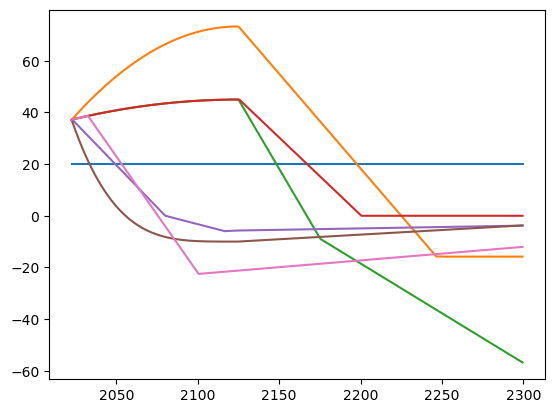

In [30]:
import matplotlib.pyplot as plt

f.emissions[272:, 0, :, 0] = 20
plt.plot(f.timepoints[272:], f.emissions[272:, :, 0, 0])


In [31]:
f.emissions

<xarray.DataArray (timepoints: 550, scenario: 7, config: 841, specie: 61)> Size: 2GB
array([[[[ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
         [ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
         [ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
         ...,
         [ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
         [ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
         [ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan]],

        [[ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
         [ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
         [ 9.30608400e-03,  1.09921740e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan],
...
                      nan,             nan,             nan],
         [-3.73500000e+00,  0.00000000e+00, -3.73500000e+00, ...,
                      nan,             nan,             nan],
         [-3.73500000e+00,  0.00000000e+00, -3.73500000e+00, ...,
                      nan,             nan,             nan]],

        [[-1.20525000e+01,  0.00000000e+00, -1.20525000e+01, ...,
                      nan,             nan,             nan],
         [-1.20525000e+01,  0.00000000e+00, -1.20525000e+01, ...,
                      nan,             nan,             nan],
         [-1.20525000e+01,  0.00000000e+00, -1.20525000e+01, ...,
                      nan,             nan,             nan],
         ...,
         [-1.20525000e+01,  0.00000000e+00, -1.20525000e+01, ...,
                      nan,             nan,             nan],
         [-1.20525000e+01,  0.00000000e+00, -1.20525000e+01, ...,
                      nan,             nan,             nan],
         [-1.20525000e+01,  0.00000000e+00, -1.20525000e+01, ...,
                      nan,             nan,             nan]]]],
      shape=(550, 7, 841, 61))
Coordinates:
  * timepoints  (timepoints) float64 4kB 1.75e+03 1.752e+03 ... 2.3e+03
  * scenario    (scenario) <U17 476B 'high-extension' ... 'verylow-overshoot'
  * config      (config) int64 7kB 1234 2451 5859 ... 1592589 1594247 1597937
  * specie      (specie) <U43 10kB 'CO2 FFI' ... 'Equivalent effective strato...

In [32]:
f.forcing.sel(specie="Volcanic")

<xarray.DataArray (timebounds: 551, scenario: 7, config: 841)> Size: 26MB
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.29377123, 0.25583418, 0.22827092, ..., 0.22882887,
         0.24933307, 0.3569714 ],
        [0.29377123, 0.25583418, 0.22827092, ..., 0.22882887,
         0.24933307, 0.3569714 ],
        [0.29377123, 0.25583418, 0.22827092, ..., 0.22882887,
         0.24933307, 0.3569714 ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], shape=(551, 7, 841))
Coordinates:
  * timebounds  (timebounds) float64 4kB 1.75e+03 1.751e+03 ... 2.3e+03
  * scenario    (scenario) <U17 476B 'high-extension' ... 'verylow-overshoot'
  * config      (config) int64 7kB 1234 2451 5859 ... 1592589 1594247 1597937
    specie      <U43 172B 'Volcanic'

There's one slight adjustment we need to make - in order to ensure that the solar and volcanic scale factors are picked up, we have to manually adjust the forcing time series. In future, we hope to make this a little more automatic. See https://github.com/OMS-NetZero/FAIR/issues/126.

In [33]:
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)

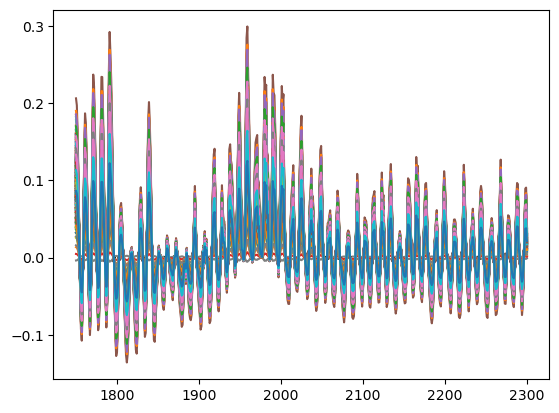

In [18]:
pl.plot(f.timebounds, f.forcing.loc[dict(specie="Solar", scenario="medium-extension")]);

### 8b. Fill in climate_configs and species_configs

The new convenience methods in v2.2 make this very easy indeed. First we fill in the default values from the `species_configs` file, and then we use our 86 parameter set for 841 ensemble members to change all of the parameters that are pertinent to the key model responses.

In [34]:
f.fill_species_configs(fair_species_configs_1_4_1_file)
f.override_defaults(fair_params_1_4_1_file)

### 8c. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [35]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)

## 9. Run

We have a total of 7 scenarios and 841 ensemble members for 550 years and 61 species. This can be a little memory constrained on some systems.

In [36]:
f.run()

Running 5887 projections in parallel: 100%|██████████| 550/550 [00:42<00:00, 13.08timesteps/s]


## 10. Analysis

In [37]:
fancy_titles = {
    'high-extension': 'High extension',
    'high-overshoot': 'High overshoot',
    'medium-extension': 'Medium extension',
    'medium-overshoot': 'Medium overshoot',
    'low': 'Low',
    'verylow': 'Very low',
    'verylow-overshoot': 'Very low overshoot',
}

colors = {
    'high-extension': '#800000',
    'high-overshoot': '#ff0000',
    'medium-extension': '#c87820',
    'medium-overshoot': '#d3a640',
    'low': '#098740',
    'verylow': '#0080d0',
    'verylow-overshoot': '#100060',
}

### Temperature anomaly

We define an anomaly baseline of 1850-1900. This is 51 complete years. As FaIR temperature anomalies are on `timebounds`, we take mid-year temperatures as averages of the bounding `timebounds`; so, 1850.5 is an average of 1850.0 and 1851.0. It means we take an average period of 1850-1901 timebounds with 0.5 weights for 1850 and 1901 and 1.0 weights for other `timebounds`.

In [38]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

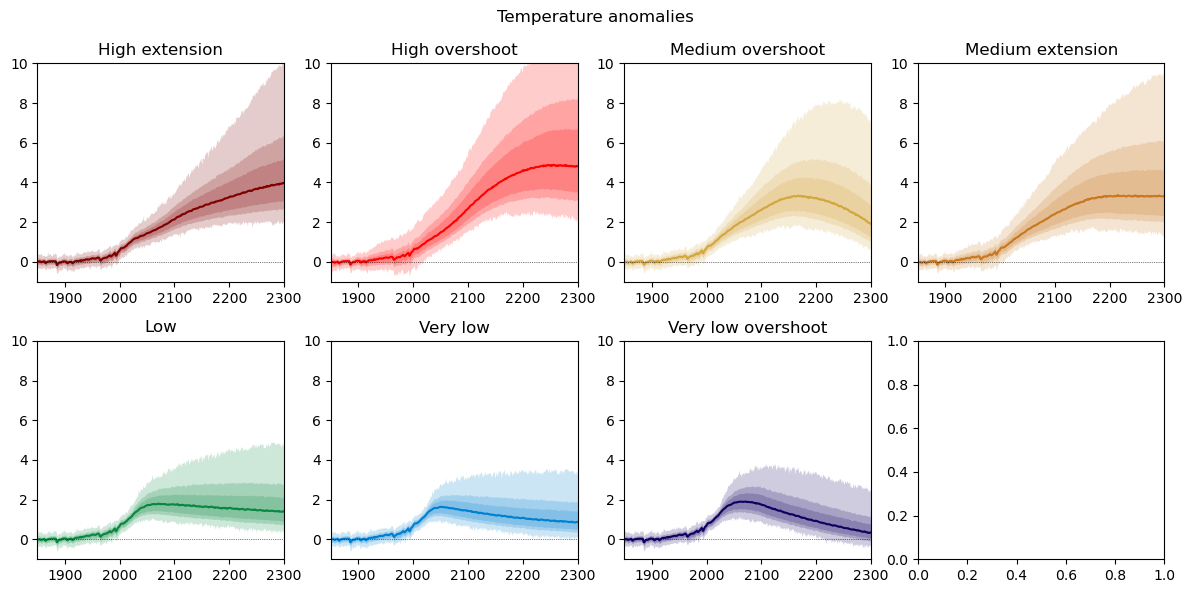

In [39]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(-1, 10)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("Temperature anomalies")
fig.tight_layout()

### CO2 concentrations

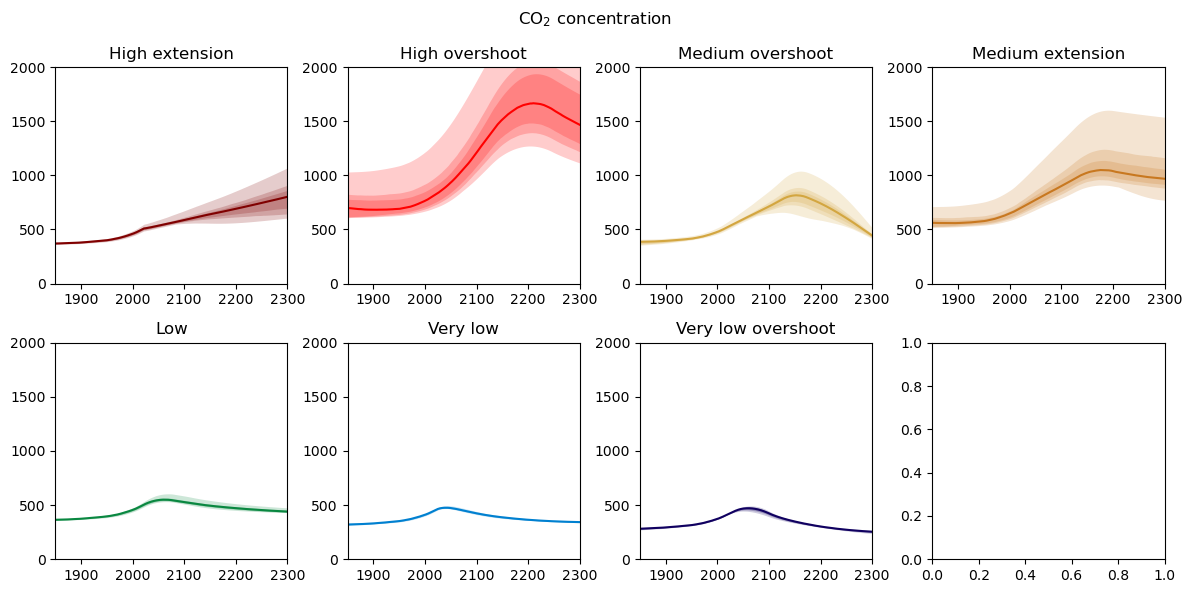

In [40]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.concentration.loc[dict(scenario=scenario, specie='CO2')],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.concentration.loc[dict(scenario=scenario, specie='CO2')],
                pp[1],
                axis=1,
            ),
            color=colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.concentration.loc[dict(scenario=scenario, specie='CO2')],
            axis=1,
        ),
        color=colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(0, 2000)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("CO$_2$ concentration")
fig.tight_layout()

### Total effective radiative forcing

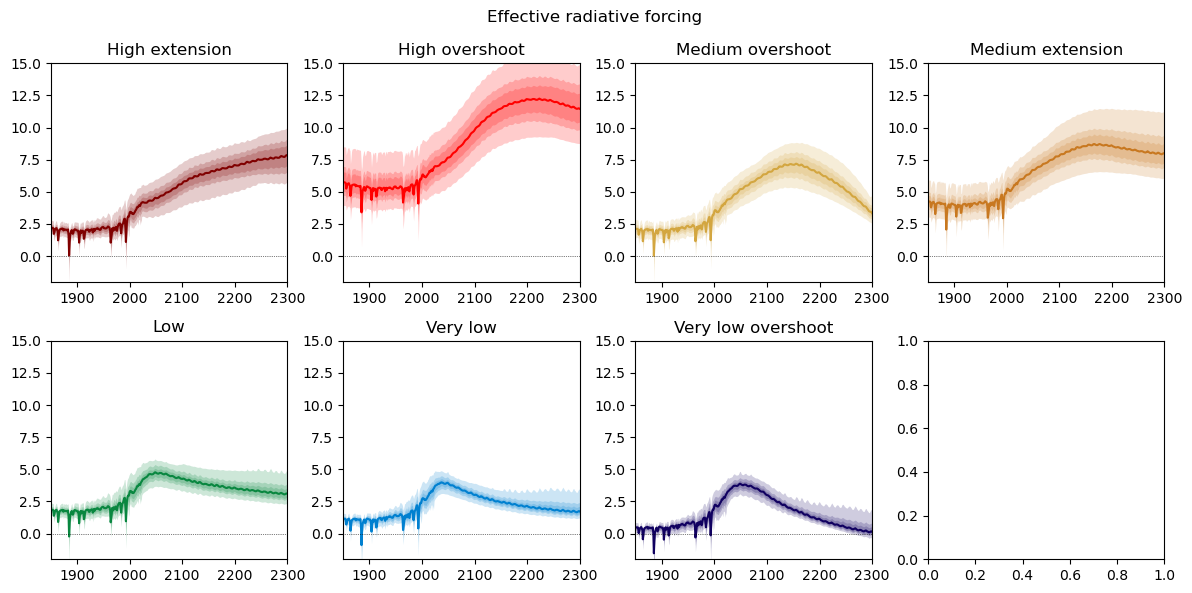

In [41]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.forcing_sum.loc[dict(scenario=scenario)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.forcing_sum.loc[dict(scenario=scenario)],
                pp[1],
                axis=1,
            ),
            color=colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.forcing_sum.loc[dict(scenario=scenario)],
            axis=1,
        ),
        color=colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(-2, 15)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("Effective radiative forcing")
fig.tight_layout()

### CO2 airborne fraction

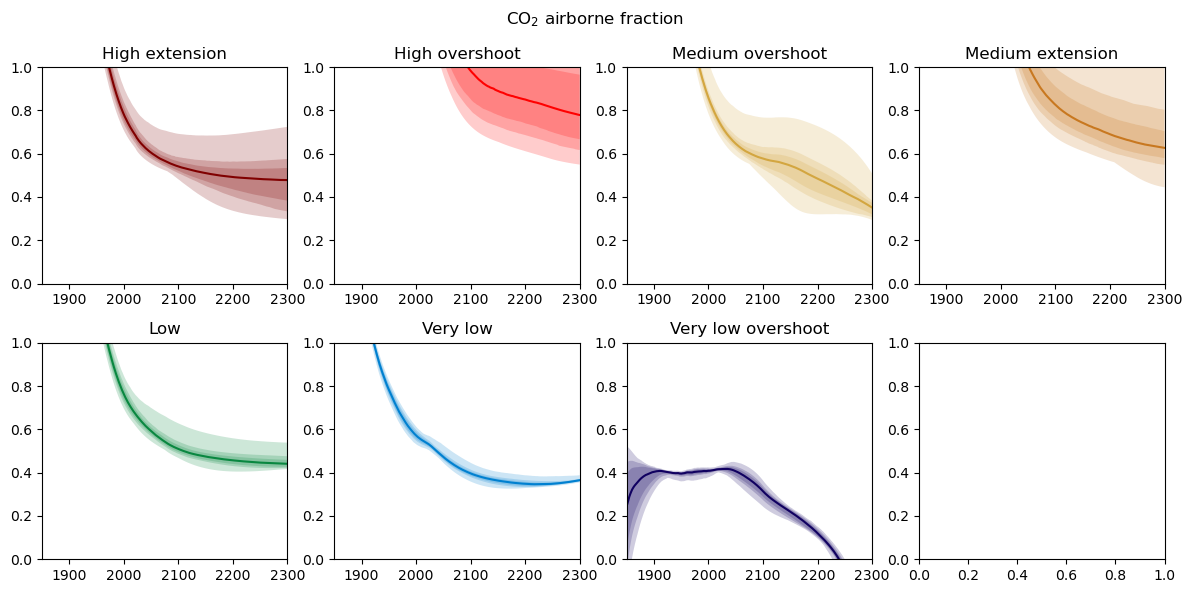

In [42]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
                pp[1],
                axis=1,
            ),
            color=colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
            axis=1,
        ),
        color=colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(0, 1)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("CO$_2$ airborne fraction")
fig.tight_layout()

### Earth's energy uptake

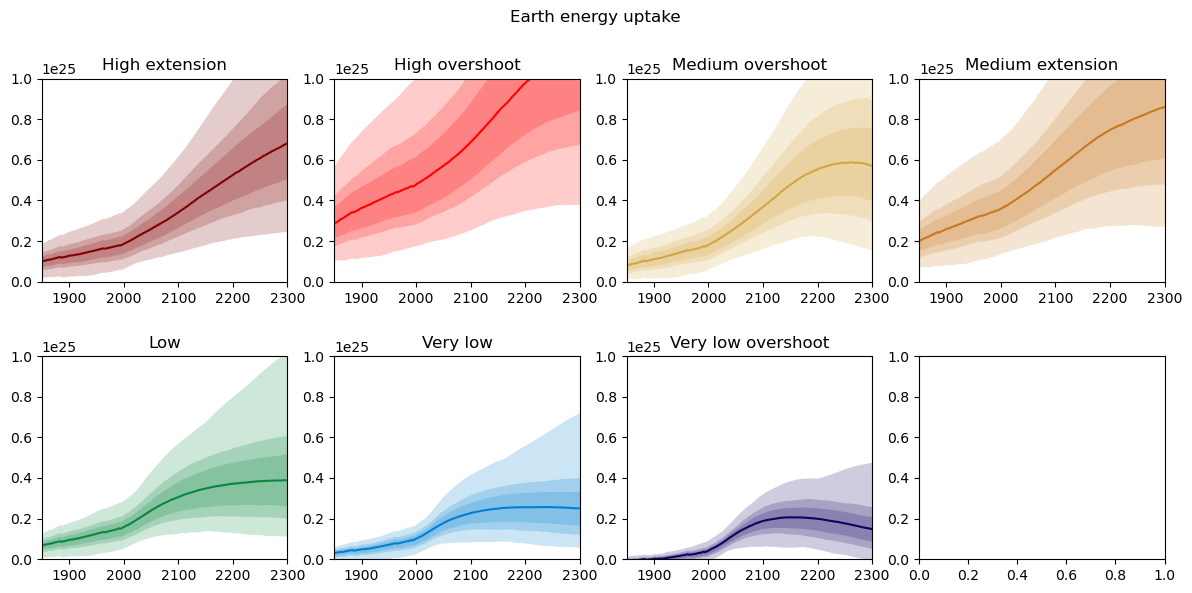

In [43]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.ocean_heat_content_change.loc[dict(scenario=scenario)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.ocean_heat_content_change.loc[dict(scenario=scenario)],
                pp[1],
                axis=1,
            ),
            color=colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.ocean_heat_content_change.loc[dict(scenario=scenario)],
            axis=1,
        ),
        color=colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(0, 1e25)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("Earth energy uptake")
fig.tight_layout()